# Kaggle Mini-Project: Disaster Tweets

<https://www.kaggle.com/competitions/nlp-getting-started/overview>

Neil Chen, University of Colorado Boulder

Mar 30, 2025

## 1. Brief Description

Disaster Tweets is a Kaggle project to predict which tweets are about real disasters and which ones are not.

It's a NLP problem, where we need to do binary classification based on tweet texts. The dataset has `7613` samples, which is quite small.

The dataset has a few metadata related columns like `keyword`, `location`, but we won't care much about these, and will only focus on predicting whether a tweet is about a disaster based on the `text` column, and the `target` column contains 0/1 labels for the training dataset.

Speaking of NLP, I took some training by following this tutorial to get my self familiar with basic concepts and training procedures: <https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial>.

For a NLP task, first we will need to tokenize the text into words, and then can transform the word statistics data into vectors. There are several techniques for text vectorization, like simple counting, TF/IDF etc.

Then we can design a model to do the training.
We can first try with a linear regression model as the baseline, and then try with more advanced deep learning models like LSTM and so on, because text are sequential data, with such models hopefully we can learn the underlying meanings (whether it is about a disaster or not) of the text.

In [72]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. Exploratory Data Analysis (EDA)

In [65]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

Check the training data:

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [82]:
# Check null values
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

We can see that the null values only exist in `location` and `keyword` columns, but since we won't do training based on these columns, it doesn't matter.

Next we check the test data:

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


So now we have 7613 samples of training data, and 3263 samples of test data.

Now let's take a look at what does a non-disaster related tweet look like:

In [7]:
train_df[train_df["target"] == 0]["text"].values[2]

'Summer is lovely'

and what does a disaster related tweet look like:

In [8]:
train_df[train_df["target"] == 1]["text"].values[3]

'13,000 people receive #wildfires evacuation orders in California '

Next let's check whether the `target` value in the training data has evenly distributed number of 0 or 1 values:

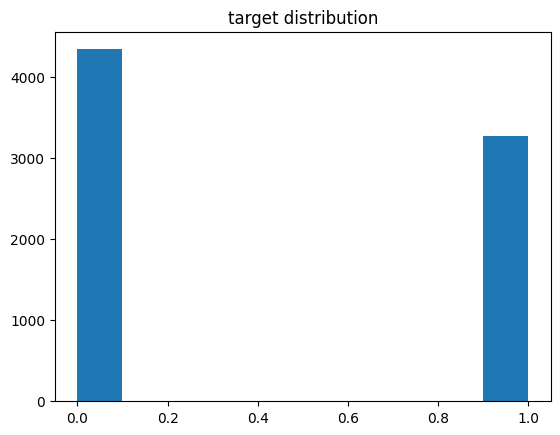

In [23]:
train_df['target'].value_counts(normalize=True)

plt.hist(train_df['target'])
plt.title('target distribution')
plt.show()

So the distribution is quite even, which is good for the training.

We can also check about the top-10 `keyword` and `location` data to get some intuition of the data.

Text(0.5, 1.0, 'Top 10 Keywords by Count')

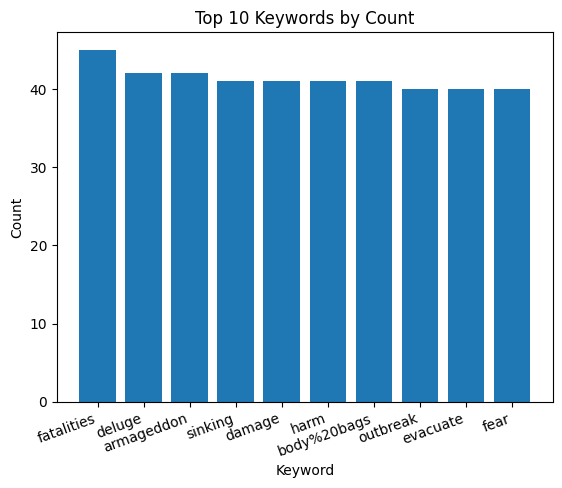

In [45]:
# Check keywords
top_10_keywords = train_df['keyword'].value_counts().head(10)
plt.bar(top_10_keywords.index.tolist(), top_10_keywords.values.tolist())
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=20, ha='right') # Rotate the x labels to avoid collision
plt.title('Top 10 Keywords by Count')


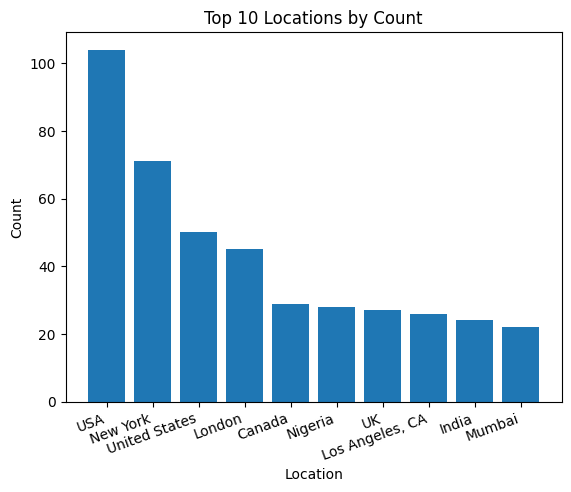

In [84]:
# Check top 10 locations
top_10_locations = train_df.location.value_counts().head(10)
plt.bar(top_10_locations.index.tolist(), top_10_locations.values.tolist() )
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=20, ha='right') # Rotate the x labels to avoid collision
plt.title('Top 10 Locations by Count')
plt.show()

We can also check text length distributions:

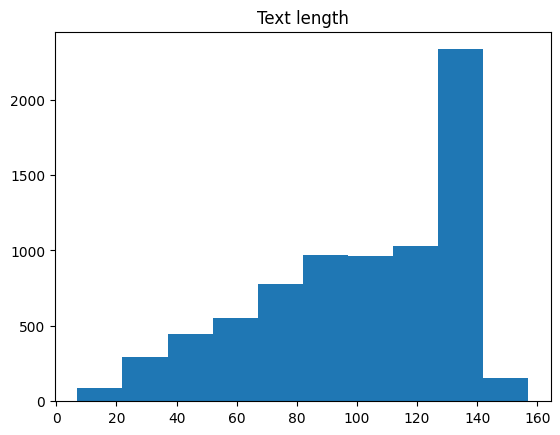

In [86]:
# Check text length distribution
text_len = [len(txt) for txt in train_df['text']]
plt.hist(text_len)
plt.title('Text length')
plt.show()

and count of words distribution as well,

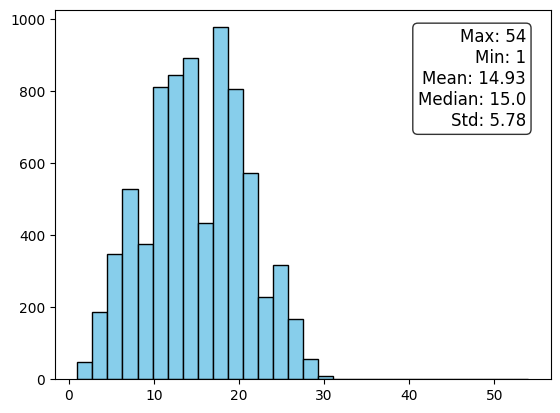

In [ ]:
# Check count of words distribution
count_words = [len(txt.split(' ')) for txt in train_df['text']]

max_words = max(count_words)
min_words = min(count_words)
mean_words = np.mean(count_words)
median_words = np.median(count_words)
std_words = np.std(count_words)

stats_text = f'Max: {max_words}\nMin: {min_words}\nMean: {mean_words:.2f}\nMedian: {median_words}\nStd: {std_words:.2f}'
plt.hist(count_words, bins=30, color='skyblue', edgecolor='black')
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

We see that the count of words in a tweet is less than 30, and the distribution looks normal.


## Preprocessing: Vectorize the text data

Now let's try with the `CountVectorizer` first.

In [94]:
# Building vectors
count_vectorizer = feature_extraction.text.CountVectorizer()

# get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [95]:
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [96]:
# get counts for the whole training data
train_vectors = count_vectorizer.fit_transform(train_df["text"])
print('Vocabulary size: ', len(count_vectorizer.vocabulary_))

# For test data, we use `transform` instead of `fit_transform`, 
# because we don't want to embed the words from the test dataset, only
# preprocess the test text for prediction purpose
test_vectors = count_vectorizer.transform(test_df["text"])

Vocabulary size:  21637


The vocabulary size might be a bit large (ideally 5k ~ 15k), but we will train this data first as a baseline and revisit later, to see if applying some preprocessing helps, like excluding stop words and so on.

## 3. Model Architecture

### Baseline Model: RidgeClassifier

Let's first use a standard `RidgeClassifier` as baseline model, which is a linear regression model.

In [97]:
clf = linear_model.RidgeClassifier()

In [98]:
# Evaluate a score by cross validation
# cv=3 means 3-fold
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59453669, 0.5642787 , 0.64082434])

In [99]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier()

Apply the model to predict test data.

In [100]:
clf.predict(test_vectors)

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

### More Advanced Deep Learning Models

### LSTM

In [101]:
# Expand dimensions by adding a time dimension. The resulting shape is (7613, 1, features)
train_vectors = train_vectors.todense()
train_vectors = np.expand_dims(train_vectors, axis=1)

X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               11144192  
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 11,152,513
Trainable params: 11,152,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [======================

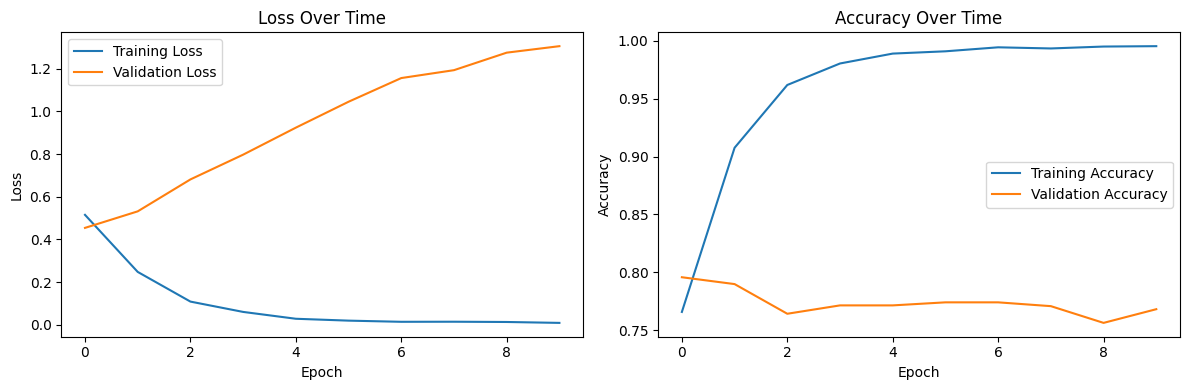

In [102]:
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=128, input_shape=(train_vectors.shape[1], train_vectors.shape[2]),
               return_sequences=False)) # only return the output of the last step

# Avoid overfitting
model.add(Dropout(0.2))

# Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer, use sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: , {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# visulization
plt.figure(figsize=(12, 4))

# render loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# render accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [103]:
print("train_vectors shape:", train_vectors.shape)
print("train_vectors type:", type(train_vectors))

train_vectors shape: (7613, 1, 21637)
train_vectors type: <class 'numpy.ndarray'>


We achieved `76.6%` validation accuracy with the LSTM model, but as the validation loss increases, the model overfits very quickly.

### Improvement: Data Cleaning

Now let's try to do some data cleaning to see if it improves:

1. Normalize the text to all lower case, to avoid duplications in the vocabulary.
2. Remove stop words
3. Remove punctuations
4. Apply stemming of the words (for example: 'running' -> 'run')
5. Exclude the noise words which only appear once, to exclude typos or rare words.


In [115]:
import re
from nltk.stem import PorterStemmer

def my_clean_text(text):
    text = text.lower()  # 小写
    text = re.sub(r'[^\w\s]', '', text)  # 移除标点
    text = re.sub(r'\d+', '', text)  # 移除数字
    
    # stem text
    ps = PorterStemmer()
    text = ' '.join(ps.stem(word) for word in text.split())
    return text

cleaned_texts = train_df['text'].apply(my_clean_text)

vectorizer = feature_extraction.text.CountVectorizer(stop_words='english', min_df=2) # min_df helps exclude rare words
train_vectors = vectorizer.fit_transform(cleaned_texts)
print("Vocabulary size after cleaning:", len(vectorizer.vocabulary_))


Vocabulary size after cleaning: 5165


The vocabulary is much smaller than before, which looks good! Let's try out the model again.

In [116]:
# Expand dimensions by adding a time dimension. The resulting shape is (7613, 1, features)
train_vectors = train_vectors.todense()
train_vectors = np.expand_dims(train_vectors, axis=1)

X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               2710528   
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,718,849
Trainable params: 2,718,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [=======================

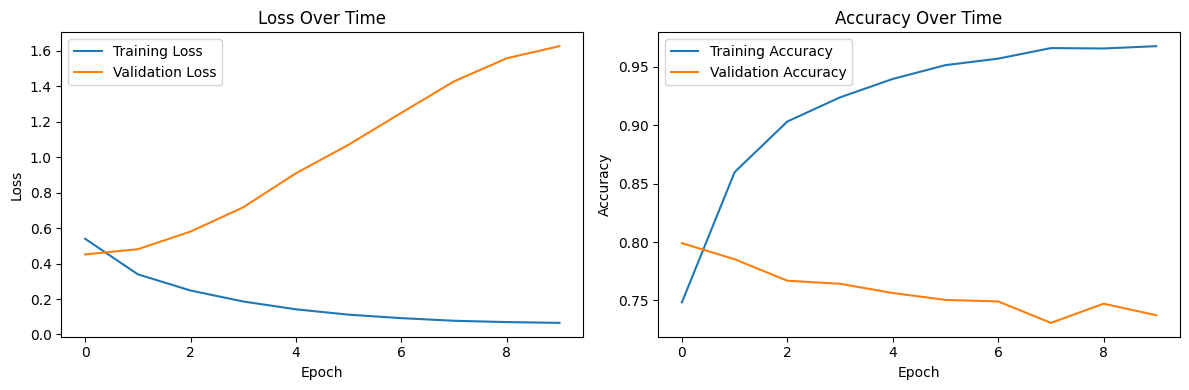

In [117]:
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=128, input_shape=(train_vectors.shape[1], train_vectors.shape[2]),
               return_sequences=False)) # only return the output of the last step

# Avoid overfitting
model.add(Dropout(0.2))

# Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer, use sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: , {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# visulization
plt.figure(figsize=(12, 4))

# render loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# render accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

TODO: Still not good. Let's try something else...

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               8358528   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,366,849
Trainable params: 8,366,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [========================

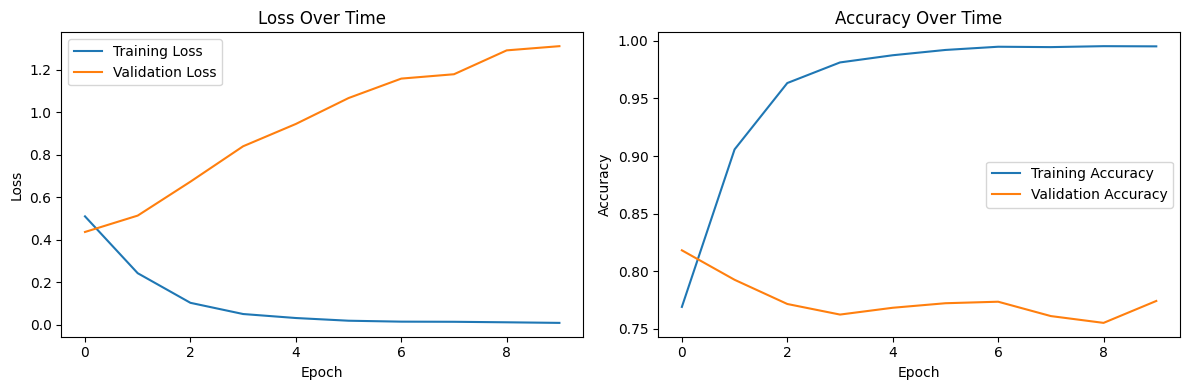

In [69]:
### Try with GRU

# With LSTM it seems to be overfitting very quickly, now we try GRU.

model = Sequential()

# Add LSTM layers
model.add(GRU(units=128, input_shape=(train_vectors.shape[1], train_vectors.shape[2]),
               return_sequences=False)) # only return the output of the last step

# Avoid overfitting
model.add(Dropout(0.2))

# Add fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer, use sigmoid for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: , {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# visulization
plt.figure(figsize=(12, 4))

# render loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# render accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

still overfitting...

In [71]:
print(train_vectors.shape[2])

21637


There are too many dimensions (> 10k), it means we need to do some dimension reduction.

Also, CountVectorizer do not capture word ordering information.

In [78]:
# Improve input representation
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary size
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])
train_vectors = pad_sequences(sequences, maxlen=50)  # max sequence length
print("New shape:", train_vectors.shape)  # (7613, 50)

New shape: (7613, 50)


In [79]:
# Expand dimensions by adding a time dimension. The resulting shape is (7613, 1, features)
# train_vectors = np.expand_dims(train_vectors, axis=1)

X_train, X_val, y_train, y_val = train_test_split(train_vectors, train_df['target'], test_size=0.2, random_state=42)

In [80]:
# improve model
model = Sequential()
model.add(Embedding(5000, 128, input_length=50))  # 嵌入层
model.add(LSTM(64, return_sequences=False))       # 减少单元数
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           640000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 691,521
Trainable params: 691,521
Non-tr

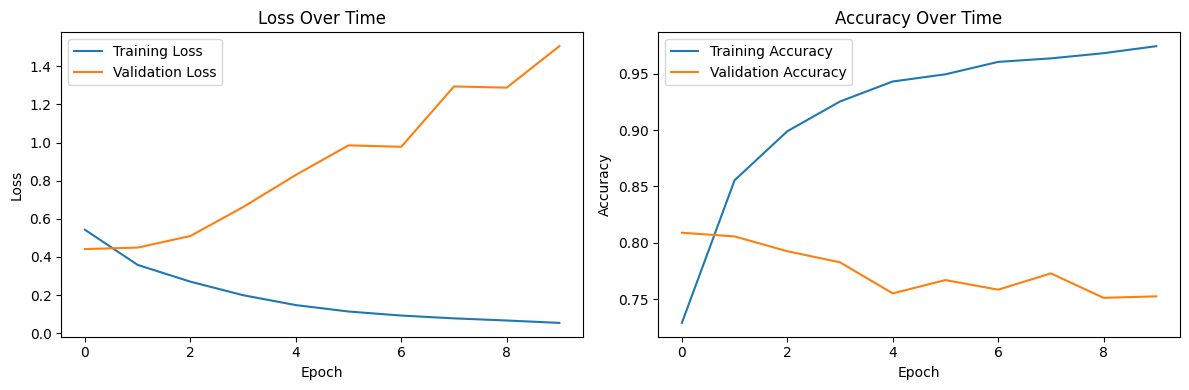

In [81]:
# compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# train
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: , {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

# visulization
plt.figure(figsize=(12, 4))

# render loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# render accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()